In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

%matplotlib inline
torch.manual_seed(1)

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

In [2]:
def findFiles(path): return glob.glob(path)

In [3]:
base_path = '/media/gaurav/New Volume/Learning/ArtificialIntelligence/data/rnn/pytorch_charRnn/'
filePath = os.path.join(os.getcwd(),base_path+'GenCharRnn_data/names/*.txt')
fileWithNames = findFiles(filePath)

In [4]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
base_path = '/media/gaurav/New Volume/Learning/ArtificialIntelligence/data/rnn/pytorch_charRnn/'
print(base_path+'data/names/*.txt')
category_lines = {}
all_categories = []
for filename in findFiles(base_path+'GenCharRnn_data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

/media/gaurav/New Volume/Learning/ArtificialIntelligence/data/rnn/pytorch_charRnn/data/names/*.txt
# categories: 18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
O'Neal


In [5]:
# category_dim = n_categories
class GenRNN(nn.Module):
    def __init__(self,inp_dim,out_dim,hidden_dim,category_dim):
        super(GenRNN, self).__init__()
        self.hidden_size = hidden_dim
        self.i2o = nn.Linear(category_dim+inp_dim+hidden_dim,out_dim)
        self.i2h = nn.Linear(category_dim+inp_dim+hidden_dim,hidden_dim)
        self.o2o = nn.Linear(hidden_dim+out_dim,out_dim)
        self.dropout = nn.Dropout(p=0.1) # isn't this very low?
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self,category,inp,hidden_prev):
        combined = torch.cat((category,inp,hidden_prev),dim=1)
        out1 = self.i2o(combined)
        hidden = self.i2h(combined)
        out_combined = torch.cat((hidden,out1),dim=1)
        out2 = self.softmax(self.dropout(self.o2o(out_combined)))
        
        return out2, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)    

In [6]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [7]:
import random
# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [8]:
# Turn a word(name) to a Tensor such that each letter is represented as a one-hot vector
def one_hot_encoded_tensor(name):
    letter_tensor = torch.zeros([len(name),1,n_letters])
    indices = []
    for i,c in enumerate(name):
        idx = all_letters.find(c)
        # is there a better way to create a one-hot encoded vector?
        letter_tensor[i][0][idx] = 1
    return letter_tensor

In [9]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(rnn, category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    
    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    # back prop
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

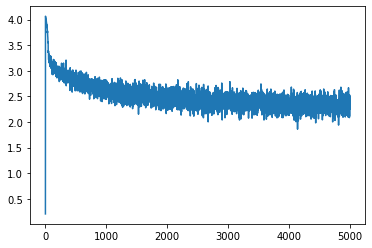

In [10]:
rnn = GenRNN(n_letters,n_letters,128,n_categories)
all_losses = []
num_epochs = 100000
total_loss = 0.
plot_every = 20

for i in range(num_epochs):
    output,loss = train(rnn,*randomTrainingExample())
    total_loss += loss
    
    if i % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0    
    
plt.plot(all_losses)
plt.show()

In [14]:
## Evaluating the network

max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Rovell
Uakovev
Shalav
Gerter
Eren
Ronger
Salla
Pare
Allan
Chan
Hang
Iun


In [15]:
rnn

GenRNN(
  (i2o): Linear(in_features=205, out_features=59, bias=True)
  (i2h): Linear(in_features=205, out_features=128, bias=True)
  (o2o): Linear(in_features=187, out_features=59, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (softmax): LogSoftmax()
)

In [ ]:
# Do the training
calc_avg_interval = 1000
categories_idx = {lang:i for i,lang in enumerate(all_categories)}
lossFunc = nn.NLLLoss()
n_hidden = 128
rnn = CharRNN(n_letters, n_hidden, n_categories)
optimizer = optim.SGD(rnn.parameters(),lr=0.001,momentum=0.9)
epochs, loop_count = 5, 0
losses, total_loss = [], 0
train_predictions = []
for _ in range(epochs):
    for sample in training_data:
        loop_count += 1
        hidden_inp = rnn.initHidden()

        optimizer.zero_grad()
        sample_encoded = one_hot_encoded_tensor(sample[0])
        for c in sample_encoded:
            output,hidden_inp = rnn(c,hidden_inp)

        max_i = torch.argmax(output)
        train_predictions.append([sample[0],sample[1],all_categories[max_i.item()]])
        loss = lossFunc(output,torch.tensor([categories_idx[sample[1]]]))
        loss.backward()
        optimizer.step()
        
        if loop_count%calc_avg_interval == 0:
            losses.append(total_loss/calc_avg_interval)
            total_loss = 0
        else:
            total_loss += loss
plt.plot(losses)
plt.show()